In [243]:
%matplotlib inline

import time
import scipy.io
import torch 
import IPython

from solver import *
import demo.args as args   # load parameters 
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Image, display



## Differentiable Feedback Delay Network for Colorless Reverberation 
Presented at the 26th International Conference on Digital Audio Effects (DAFx23), Copenhagen, Denmark, 4 - 7 September 2023  

Authors: Gloria Dal Santo, Karolina Prawda, Sebastian J. Schlecht, and Vesa Välimäki (Aalto University Acoustics Lab)  
Date created: 22.08.23  
Last modified: 3.09.23  


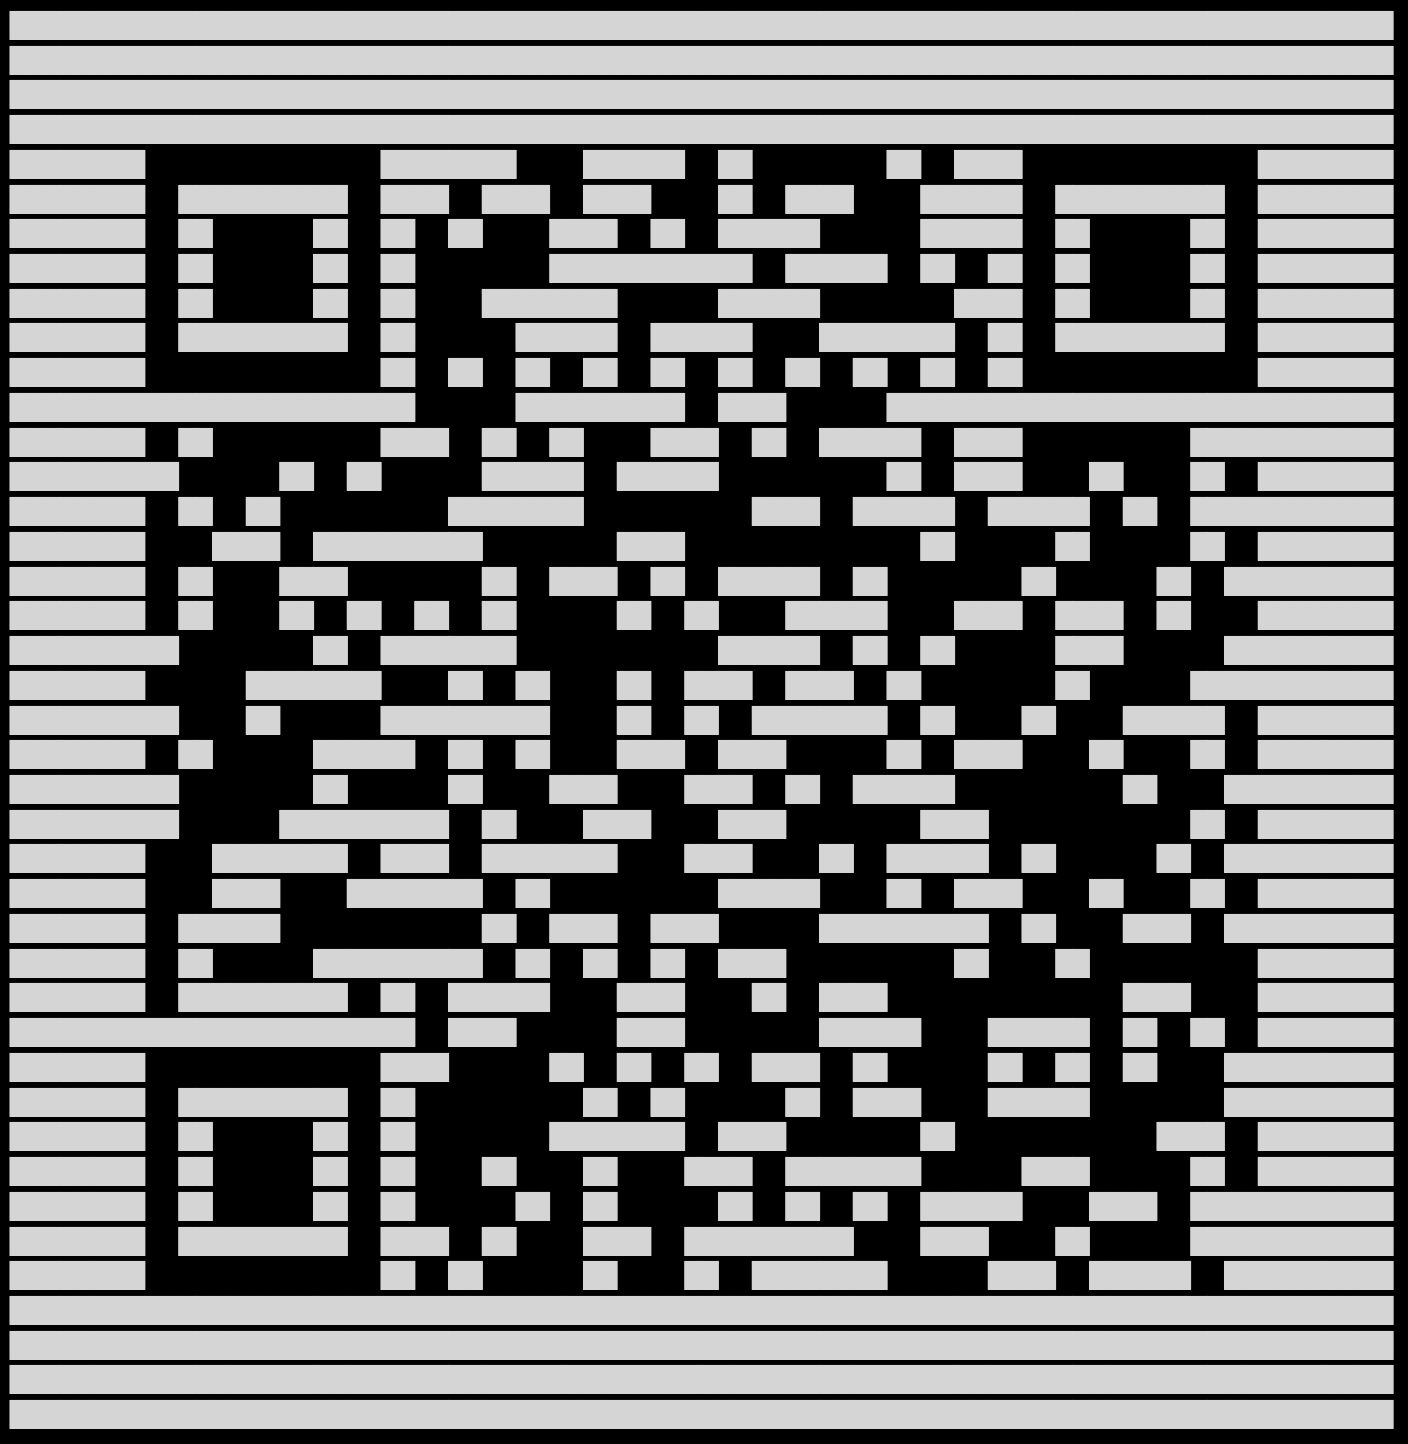

In [244]:
display(Image(filename='demo/qr_code_github.png', width=128, height=128))

### Feedback Delay Network
An FDN is a recursive system consisting of $N$ delay lines $m = [m_1, \dots, m_N]$, a set of input and output gains, $\mathbf{b} \text{ and } \mathbf{c}$ respectively,   
and a scalar feedback matrix $\mathbf{A}$ through which the delay outputs are coupled to the delay inputs.  


The transfer function of an FDN is $H(z) = \mathbf{c}^\top\big[\mathbf{D_m}(z)^{-1} -\mathbf{A}\big]^{-1}\mathbf{b} + d$   
where the delay matrix $\mathbf{D_m}(z)$ is a diagonal matrix whose diagonal entries are given by $[z^{-m_1}, \dots, z^{-m_N}]$  

#### Modal decomposition
The impulse respose (IR) of the FDN can be represented as the sum of complex one pole models, or resonators, in the time domain:   
$h(n) = \sum_{i=1}^N |\rho_i||\lambda_i|^ne^{\jmath(n\angle\lambda_i+\angle\rho_i)} $  
Similarly, the transfer fuction can be represented in terms of its poles $\lambda$ and residues $\rho$ from its partial fraction decomposition as  
$H(z) = d + \sum_{i=1}^N\frac{\rho_i}{1-\lambda_iz^{-1}}$

Pole $\lambda_i$ determines the decay rate and frequency of the $i$-th mode, while residual $\rho_i$ defines the exitation and initial phase of the $i$-th mode. 

#### Coloration in FDN
The properties of resonating modes have direct implications on coloration.  
Listening test results suggest that a narrow distribution of the modal excitation values $|\rho_i|$ end to result in a flatter magnitude repsonse, which is often desirable.


In this work, we aim to optimize $\mathbf{A}, \mathbf{b},$ and $\mathbf{c}$ such that the resulting IR is perceptually colorless.

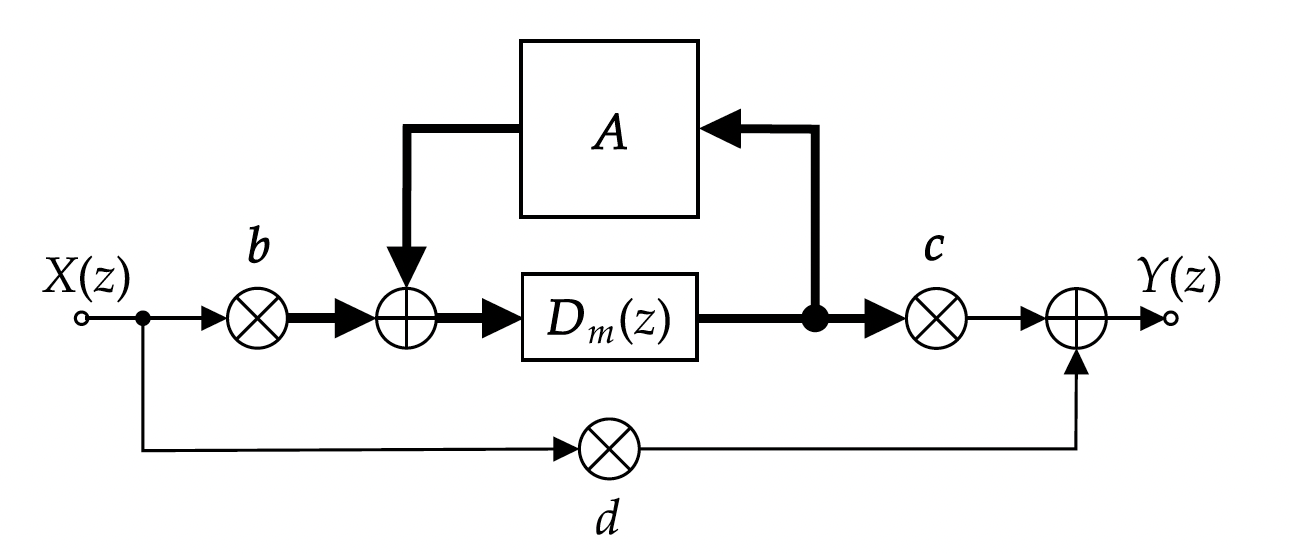

In [245]:
display(Image(filename='demo/fdn_blockdiagram.png', width=512, height=512))

#### Dataset 
This work applies the frequency-sampling method to approximate an FDN as a finite-impulse-response (FIR) filter.  
This is done by evaluating the delay matrix in the transfer function, $\mathbf{D_m}({z}_M)$, at discrete frequency points in the vector  
$\vec{z}_M = [e^{\jmath \pi \frac{0}{M}}, e^{\jmath \pi \frac{1}{M}}, \dots, e^{\jmath \pi \frac{M-1}{M}}]$  

The dataset consists of vectors of frequency points, equally distributed on the unit circle, with different length $M$.  
In this way, at every training step $H(z)$ is computed on a different set of frequency points. 


Generating dataset: 100%|██████████| 256/256 [00:00<00:00, 16186.90it/s]


Text(0, 0.5, 'Imag')

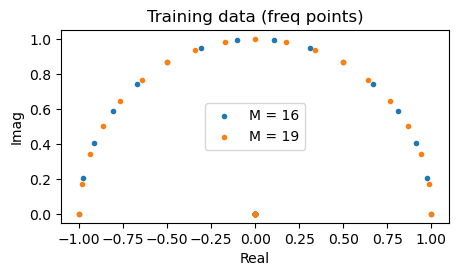

In [246]:
plt.rcParams['figure.figsize'] = [5, 2.5]

# set low value of nfft just for illustrative puproses
# during training we use max_nfft 480000
args.max_nfft = 24
args.min_nfft = 12

# load training and validation dataset
train_dataset, valid_dataset = load_dataset(args)

train_ex, _ = next(iter(train_dataset))
plt.scatter(torch.real(train_ex[0,:]), torch.imag(train_ex[0,:]), marker=".",  label='M = {}'.format(torch.count_nonzero(train_ex[0,:])))
plt.scatter(torch.real(train_ex[2,:]), torch.imag(train_ex[2,:]), marker=".",  label='M = {}'.format(torch.count_nonzero(train_ex[2,:])))

plt.legend()
plt.title("Training data (freq points)")
plt.xlabel("Real")
plt.ylabel("Imag")

### Optimization Framework
In this notebook we are loading a pretrained model that can be found in ´\demo´ .  
For the implementation of the model and the training pipeline, check ´models.py´
and ´solver.py´, respectively. 

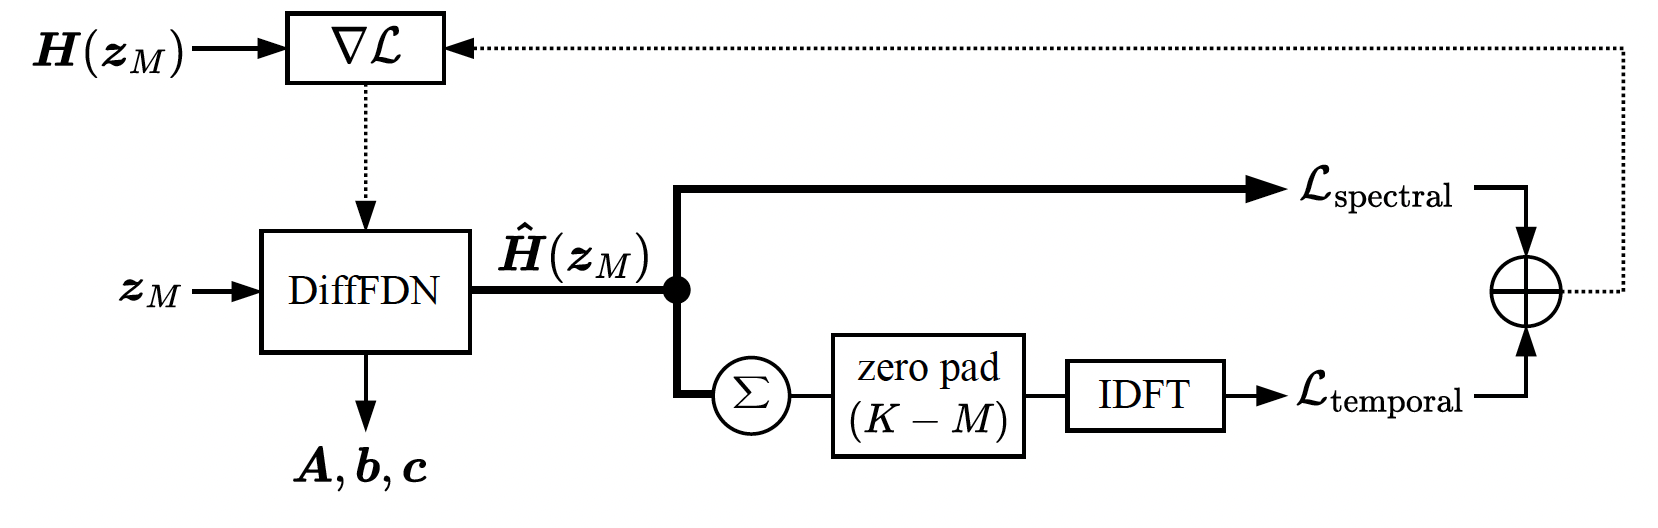

tensor([ 241.,  263.,  281.,  293., 1193., 1319., 1453., 1597.])


In [261]:
display(Image(filename='demo/diffFDN_blockdiagram.png', width=512, height=512))

args.train_dir = 'demo/pretrained04'
args.delays = [241.0, 263.0, 281.0, 293.0, 1193.0, 1319.0, 1453.0, 1597.0]
# args.delays = [809.0, 877.0, 937.0, 1049.0, 1151.0, 1249.0, 1373.0, 1499.0]
args.gain_per_sample = 0.9999
args.max_nfft = 480000
# input frequency sampling points
x = get_frequency_samples(args.max_nfft)
# load model and state
net = DiffFDN(args.delays, args.gain_per_sample, args.device)
net.load_state_dict(torch.load( 
    os.path.join(args.train_dir, 'model_e0.pt'), 
    map_location=torch.device('cpu')))
H_init, h_init, _ = net(x)
net.load_state_dict(torch.load( 
    os.path.join(args.train_dir, 'model_e' + str(args.max_epochs - 1) +'.pt'), 
    map_location=torch.device('cpu')))
H_end, h_end, _ = net(x)
# load losses
losses = scipy.io.loadmat(os.path.join(args.train_dir,'losses.mat'))
# print(net.m*net.mStd+net.mAvr)

#### Loss function 
The network is trained on two losses, $\mathcal{L}_\textrm{spectral}$ and $\mathcal{L}_\textrm{temporal}$, respectively, in frequecy and time domain.  


$\mathcal{L} = \mathcal{L}_\textrm{spectral}(\hat{\boldsymbol{H}}(\bar{z}_{M})) +\alpha \mathcal{L}_\textrm{temporal}(\hat{h})$   


The spectral loss aims to minimize the frequency-domain mean-squared error between the absolute value of the predicted   
magnitude response and the target flat magnitude response. The temporal loss penalizes sparseness in the time domain.   


$\mathcal{L} = \frac{1}{K} \sum_{i = 1}^N \sum_{k = 1}^K({{|\hat{H}_i(\bar{z}_{M}[k])|}-1})^p + \alpha \frac{||{\hat{h}}||_2}{||{\hat{h}}||_1}$

#### Initial Random Orthogonal FDN

/Users/dalsag1/miniconda3/envs/colorless-fdn/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


((-3.5, 2.0),
 (-1.0, 1.0),
 Text(0.5, 1.0, 'Magnitude response'),
 Text(0.5, 0, 'Angular Frequecy'))

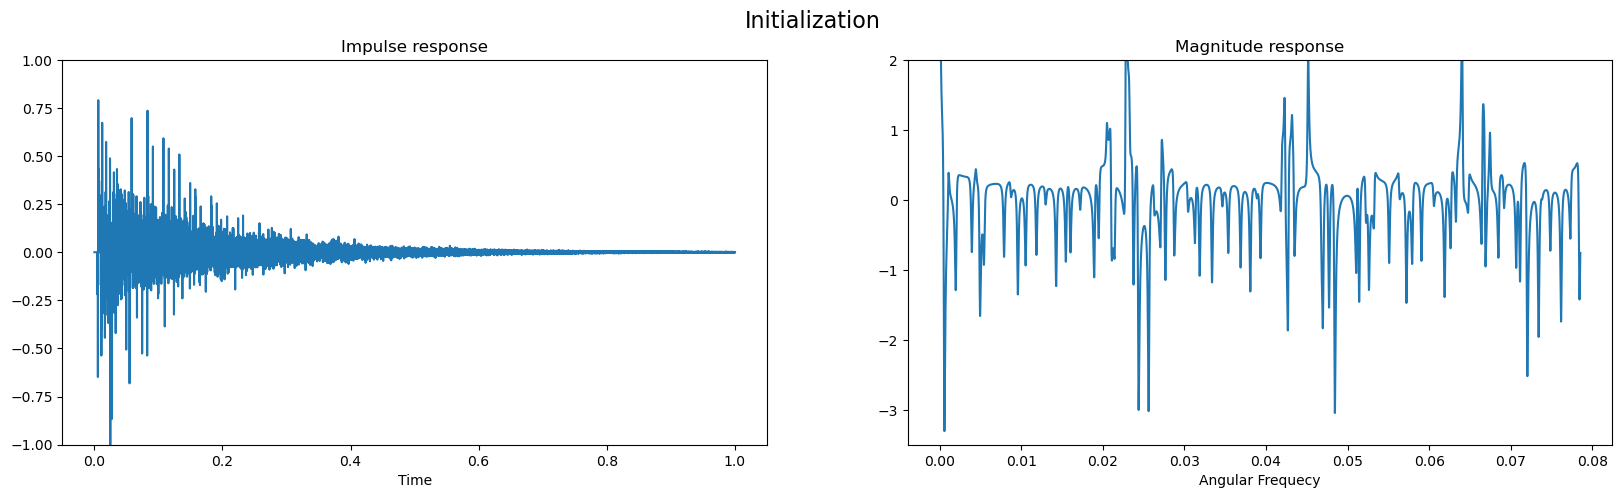

In [248]:
plt.rcParams['figure.figsize'] = [20, 5]

audio_widget = IPython.display.Audio(h_init[:2*args.samplerate].detach().numpy(), rate = args.samplerate)
IPython.display.display(audio_widget)

fig, ax = plt.subplots(1, 2)
fig.suptitle('Initialization', fontsize=16)
t = np.arange(0, 1, 1/args.samplerate)
ax[0].plot(t, h_init[:1*args.samplerate].detach().numpy())
ax[0].set_title('Impulse response'), ax[0].set_xlabel('Time')
ax[1].plot(torch.angle(x[:12000]), torch.sum(H_init, dim=-1)[:12000].detach().numpy())
ax[1].set_ylim(-3.5, 2), ax[0].set_ylim(-1, 1), ax[1].set_title('Magnitude response'), ax[1].set_xlabel('Angular Frequecy')


#### Optimized Random Orthogonal FDN
The unilossless matrix $\mathbf{U}$ is computed from the weights $\mathbf{W}$ of a parameterized linear layer. Matrix $\mathbf{U}$ is limited to the class of orthogonal matrices, satisfying the unitary condition for unilosslessness. To ensure orthogonality, at each optimization step $\mathbf{W}$ is mapped to a skew-symmetric matrix, and the matrix exponential is computed,   
$\mathbf{U} = e^{ \mathbf{W}_{\textrm{Tr}} - \mathbf{W}_{\textrm{Tr}}^\top}$,  
where $ \mathbf{W_{\textrm{Tr}}}$ is the upper triangular part of $\mathbf{W}$ and the operator $e^{ (\cdot ) }$ denotes the matrix exponential. This mapping implicitly ensures orthogonality of $\mathbf{U}$ and can be used in regular gradient descent optimizers without creating spurious minima

(-1.0, 1.0)

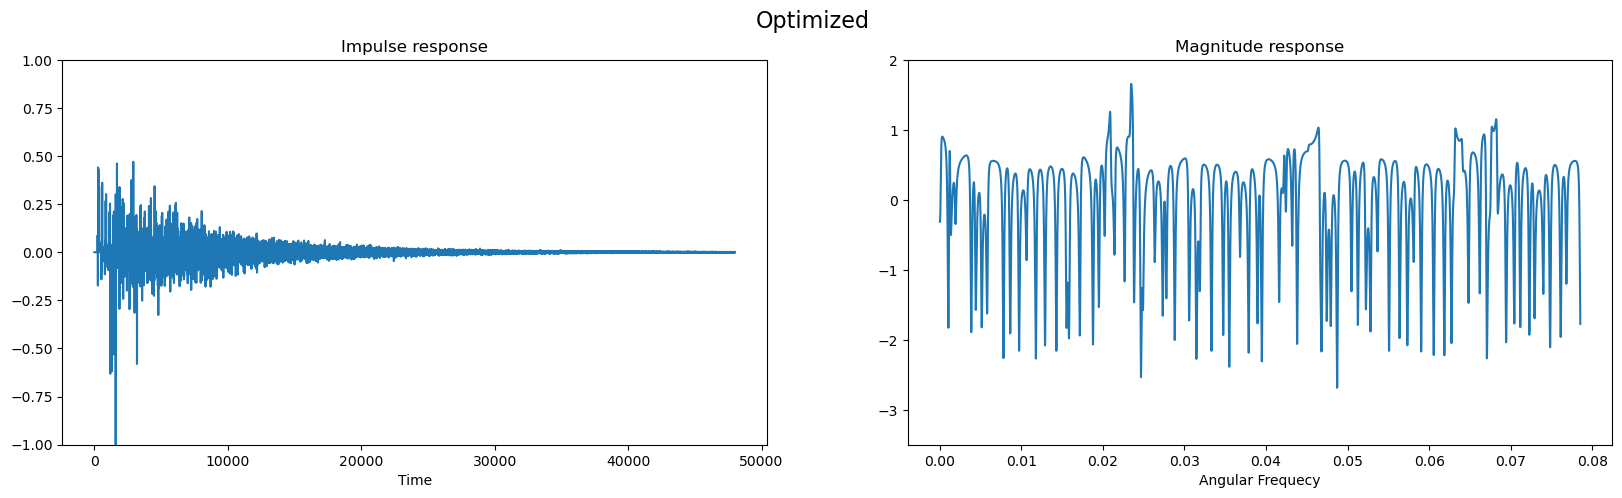

In [249]:
audio_widget = IPython.display.Audio(h_end[:2*args.samplerate].detach().numpy(), rate = args.samplerate)
IPython.display.display(audio_widget)

fig, ax = plt.subplots(1, 2)
fig.suptitle('Optimized', fontsize=16)
ax[0].plot(h_end[:1*args.samplerate].detach().numpy()), ax[0].set_title('Impulse response'), ax[0].set_xlabel('Time')
ax[1].plot(torch.angle(x[:12000]), torch.sum(H_end, dim=-1)[:12000].detach().numpy())
ax[1].set_xlabel('Angular Frequecy'), ax[1].set_title('Magnitude response'), ax[1].set_ylim(-3.5, 2) 
ax[0].set_ylim(-1, 1)

(<matplotlib.legend.Legend at 0x291513dc0>, (-1.0, 1.0))

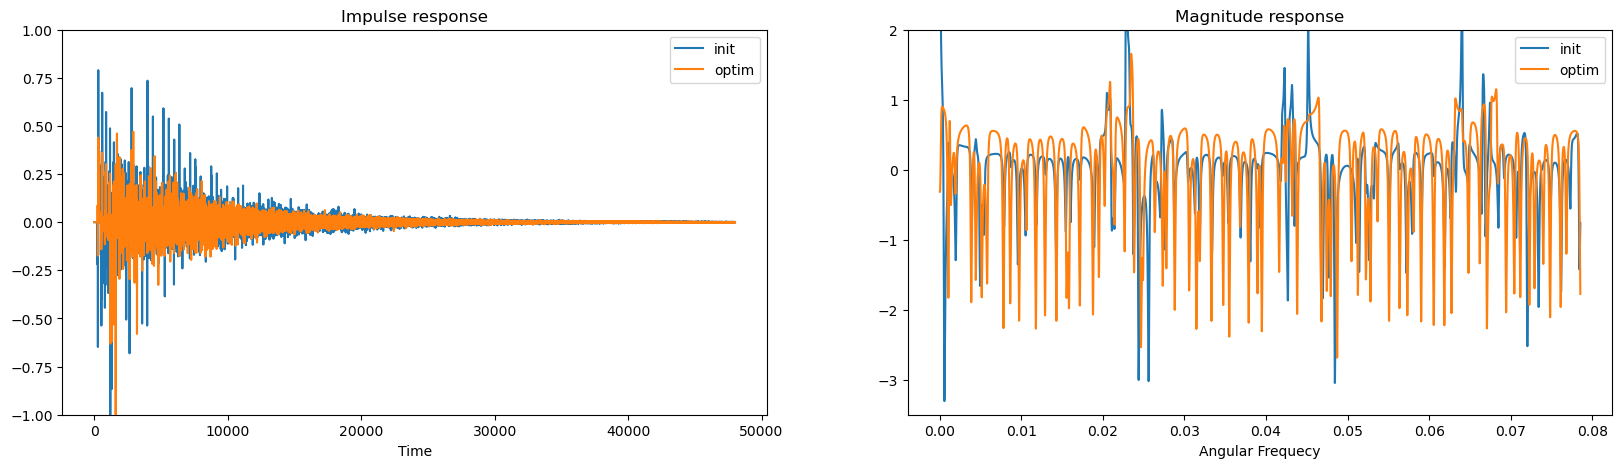

In [250]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(h_init[:1*args.samplerate].detach().numpy(), label='init')
ax[0].plot(h_end[:1*args.samplerate].detach().numpy(), label='optim')
ax[0].set_title('Impulse response'), ax[0].set_xlabel('Time'), ax[0].legend()
ax[1].plot(torch.angle(x[:12000]), torch.sum(H_init, dim=-1)[:12000].detach().numpy(), label='init')
ax[1].plot(torch.angle(x[:12000]), torch.sum(H_end, dim=-1)[:12000].detach().numpy(), label='optim')
ax[1].set_title('Magnitude response'), ax[1].set_xlabel('Angular Frequecy'), ax[1].set_ylim(-3.5, 2)
ax[1].legend(), ax[0].set_ylim(-1, 1)


#### Modal excitation distribution
Compared to the distribution at initialization, the distributon of the modal excitation of the optimized FDN is narrower.  
Moreover, the modes with highest excitation values are attuennuated. This lead to an improvement in the coloration. 

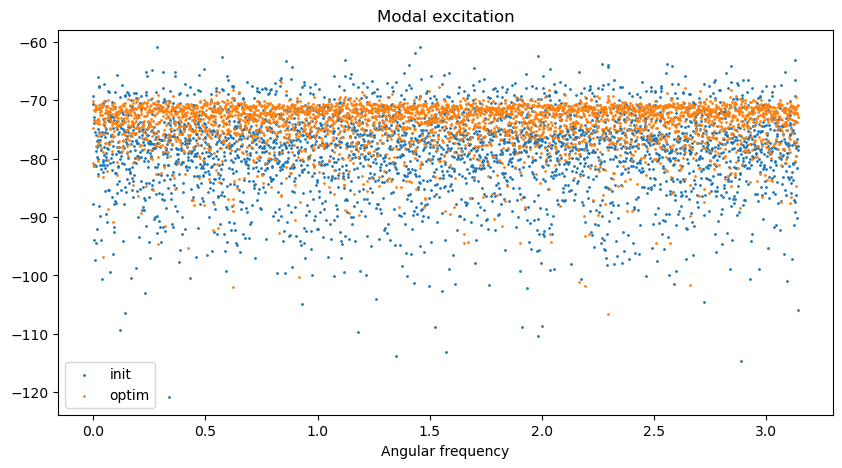

In [251]:
plt.rcParams['figure.figsize'] = [10, 5]

# load modal decomposition results
poles = scipy.io.loadmat(os.path.join(args.train_dir,'poles.mat'))['poles']
residues = scipy.io.loadmat(os.path.join(args.train_dir,'residues.mat'))['residues']
types = ["initDiffFDN", "DiffFDN"]
plt.scatter(np.angle(poles[types[0]][0][0]), 20*np.log10(np.abs(residues[types[0]][0][0])), s=1, label='init')
plt.scatter(np.angle(poles[types[1]][0][0]), 20*np.log10(np.abs(residues[types[1]][0][0])), s=1, label='optim')
plt.xlabel('Angular frequency')
plt.title('Modal excitation')
plt.legend()

#### Evolution of trainable parameters
The following code shows how the trainable parameters $\mathbf{A}, \mathbf{b},$ and $\mathbf{c}$ evolve during training 

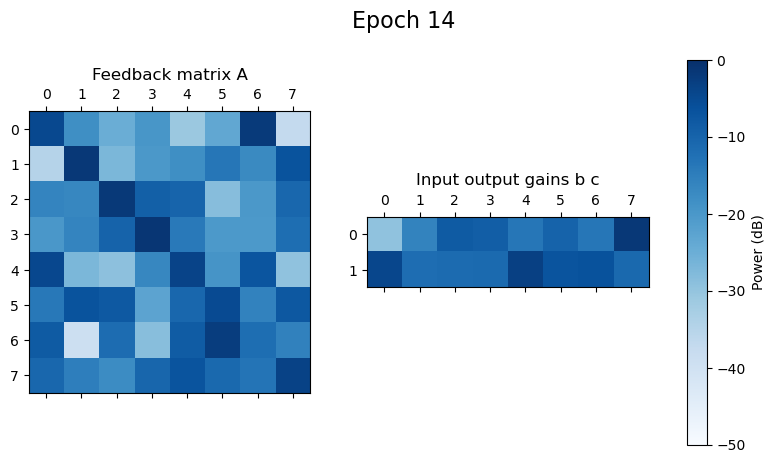

In [252]:

n_epochs = 15
args.max_nfft = 480000

fig, ax = plt.subplots(1, 2)
plt.rcParams['figure.figsize'] = [10, 5]

for epoch in range(n_epochs):
    ax[0].clear()
    ax[1].clear()
    # load model parameters
    net.load_state_dict(torch.load( 
        os.path.join(args.train_dir, 'model_e' + str(epoch) + '.pt'), 
        map_location=torch.device('cpu')))
    # plot feedback matrix 
    im = ax[0].matshow(
        20*np.log10(torch.abs(net.A.weight).detach().numpy()), cmap=plt.cm.Blues, 
        vmin = -50, vmax = 0)
    ax[0].set_title('Feedback matrix A')
    # plot input output gains
    im = ax[1].matshow(
        20*np.log10(torch.vstack(
            (torch.abs(net.B.data).squeeze(dim=0).transpose(1, 0).squeeze(dim=0),
            torch.abs(net.C.data).squeeze(dim=0))).detach().numpy()), 
            cmap=plt.cm.Blues, 
        vmin = -50, vmax = 0)
    ax[1].set_title('Input output gains b c')
    fig.suptitle('Epoch ' + str(epoch) , fontsize=16)

    # fig.canvas.flush_events()
    # Add a colorbar
    
    if epoch == 0:
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', ticks=[0, -10, -20, -30, -40, -50])
        cbar.set_label('Power (dB)')
        cbar.set_ticks([0, -10, -20, -30, -40, -50])
    
    IPython.display.display(fig)
    time.sleep(1)
    IPython.display.clear_output(wait=True)
    

In [260]:

filenames = os.listdir(os.path.join(args.train_dir, 'ir'))
# types = ['Optimized Diff FDN', 'Householder','Random Orthogonal', 'Hadamard', 'Diagonal', 'Initialized Diff FDN']
for i, filename in enumerate(filenames):
    audio_ir, sr =sf.read(os.path.join(args.train_dir, 'ir', filename), dtype='float32')
    audio_widget = IPython.display.Audio(audio_ir[:2*args.samplerate], rate = sr)
    print(filename)
    IPython.display.display(audio_widget)

initialized_DiffFDN.wav


Householder.wav


Optimized_DiffFDN.wav


Hadamard.wav


Random_Orthogonal.wav


Diagonal.wav
